In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav


In [6]:
rawfilt = np.loadtxt("2MASS-2MASS.J.dat",unpack="True",skiprows=0)
# load spex spectrum and skip to 1um
rawspec = np.loadtxt("spex-prism_2MASSJ16262034+3925190_20040723_BUR04A.txt",unpack="True",skiprows=18)
rawvega = np.loadtxt("vega.txt", unpack="True", skiprows=6)
print rawfilt.shape
rawfilt[0,:] = rawfilt[0,:] / 10000.
rawvega[0,:] = rawvega[0,:] / 10000.
rawvega[1,:] = rawvega[1,:] * 10. # erg/cm/s/A to W/m2/um

(2, 107)


In [7]:
# Now trim target spectrum to wavelength region of filter, and rebin filter onto new target grid
w1 = rawfilt[0,0]
w2 = rawfilt[0,rawfilt.shape[1] -1]
trimspec =  rawspec[:,np.logical_not(np.logical_or(rawspec[0,:] > w2, rawspec[0,:] < w1))]
wfit = sp.interpolate.splrep(rawfilt[0,:],rawfilt[1,:],s=0)
filt = np.zeros_like(trimspec)
filt[0,:] = trimspec[0,:]
# should we multiply filter by lambda and renormalise to get response curve in terms of flux, instead of photons???
wfilt = sp.interpolate.splev(filt[0,:],wfit,der=0)# * filt[0,:]
filt[1,:] = wfilt
#filt[1,:] = wfilt / np.amax(wfilt)
# and vega
trimvega =  rawvega[:,np.logical_not(np.logical_or(rawvega[0,:] > w2, rawvega[0,:] < w1))]
wfit = sp.interpolate.splrep(trimvega[0,:],trimvega[1,:],s=0)
vega = np.zeros_like(trimspec)
vega[0,:] = filt[0,:]
vega[1,:] = sp.interpolate.splev(filt[0,:],wfit,der=0)

In [8]:
Mag = 14.435
intspec = sum(filt[1,:]*trimspec[1,:])
intvega = sum(filt[1,:]*vega[1,:])
scale =(10.**(-Mag/2.5)) * (intvega / intspec)
print scale
intspec = 0.
intvega = 0.
print filt.shape
sbin = np.zeros(filt.shape[1])
for i in range(1,filt.shape[1]-1):
    sbin[i]= ((trimspec[0,i] - trimspec[0,i-1]) + (trimspec[0,i+1] - trimspec[0,i])) / 2.
# Deal with the ends...
sbin[0] = sbin[1]
sbin[sbin.size-1] = sbin[sbin.size-2]
intspec = sum(sbin*filt[1,:]*trimspec[1,:])
intvega = sum(sbin*filt[1,:]*vega[1,:])
scale =(10.**(-Mag/2.5)) * (intvega / intspec)
print scale

6.53392903806e-15
(3, 92)
6.52656212053e-15


In [9]:
#scale = 9.95766136255e-15
scalespec = np.empty_like(rawspec)
scalespec[0,:] = rawspec[0,:]
scalespec[1,:] = rawspec[1,:] * scale
scalespec[2,:] = rawspec[2,:] * scale

In [10]:
np.savetxt('2M1626_2MassJcalib.dat', np.c_[scalespec[0],scalespec[1],scalespec[2]])

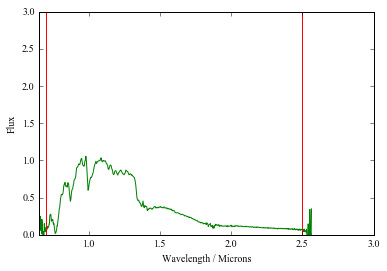

In [12]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.65, 3.0,0.0,3])


plt.plot(rawspec[0,:],rawspec[1,:],'g-')
plt.plot([0.7,0.7],[0.,3.0],'r-')
plt.plot([2.5,2.5],[0.,3.0],'r-')

plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')


In [1]:
import band

In [2]:
print band.mag2flux(15,0.2, "w1",iso=False)



(5.458953441771598e-17, 1.005576385469746e-17)


In [5]:
oldspec = np.loadtxt("10gas_TESTspectrum.dat", unpack=True)
oldspec[:,:] = oldspec[:,::-1]
print oldspec

[[  1.00000000e+00   1.00010001e+00   1.00020004e+00 ...,   9.98003992e+00
    9.99000999e+00   1.00000000e+01]
 [  8.23984116e+02   1.46503669e+03   3.96412927e+03 ...,   2.40680353e+03
    2.43804207e+03   2.32811739e+03]]


In [6]:
print band.spec2flux(oldspec,"w2")* 1e-21

2.411478007e-17
